훈련 데이터가 충분하지 않는 경우 사전훈련된 모델의 하위층 사용

### **사전훈련된 Xception 모델을 사용하여 꽃 이미지 분류**

#### **데이터 적재**

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)  # with_info=True : 데이터셋에 대한 정보
dataset_size = info.splits["train"].num_examples 
class_names = info.features["label"].names  
n_classes = info.features["label"].num_classes 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
dataset_size

3670

In [4]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
n_classes

5

#### **훈련, 검증, 테스트 세트 분리**

- (Old) TF splitAPI

In [ ]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])   # 'Split' object has no attribute 'subsplit'

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)

- (New) TF slicingAPI

In [6]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

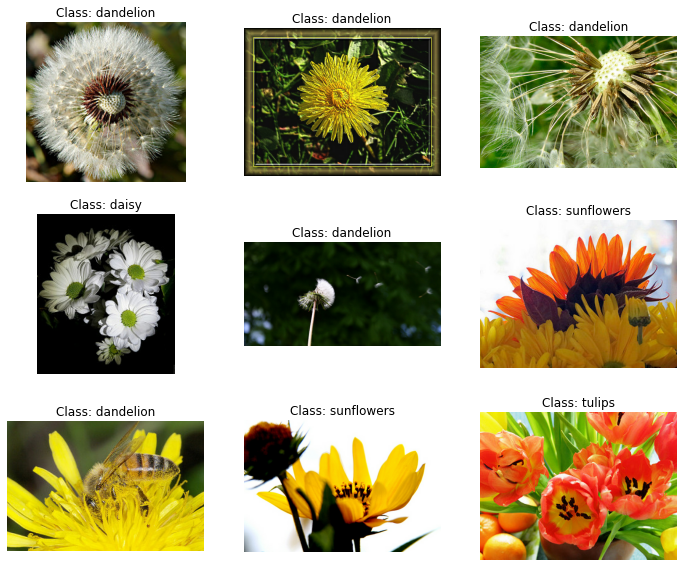

In [7]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

#### **이미지 전처리**

- 기본 전처리
    - 이미지 크기 조정 : 224 X 224
    - xception 패키지에 포함된 preprocess_input() 함수 활용

In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [14]:
batch_size = 32   # 배치 크기 지정
train_set = train_set_raw.shuffle(1000)   # 훈련 데이터 shuffle

train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1)   # 프리페치 적용
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

- 추가 전처리

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

- 전처리 결과

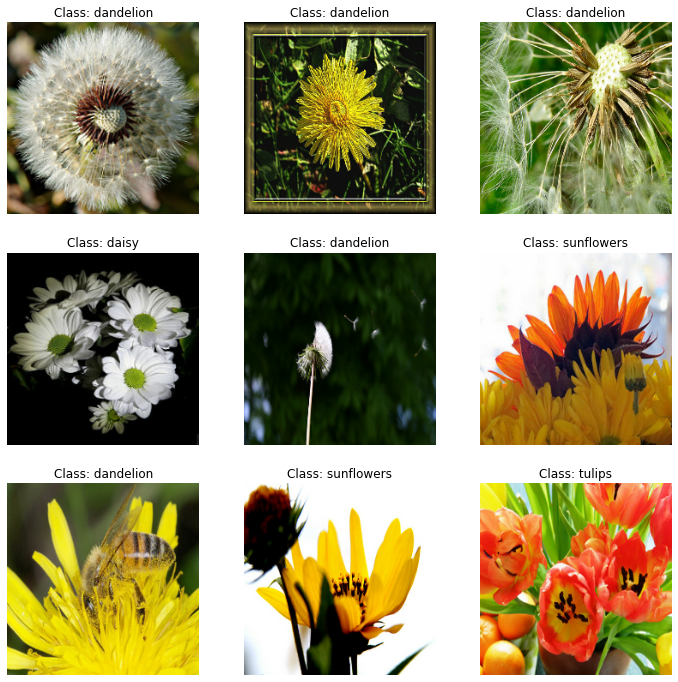

In [15]:
# train_set
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

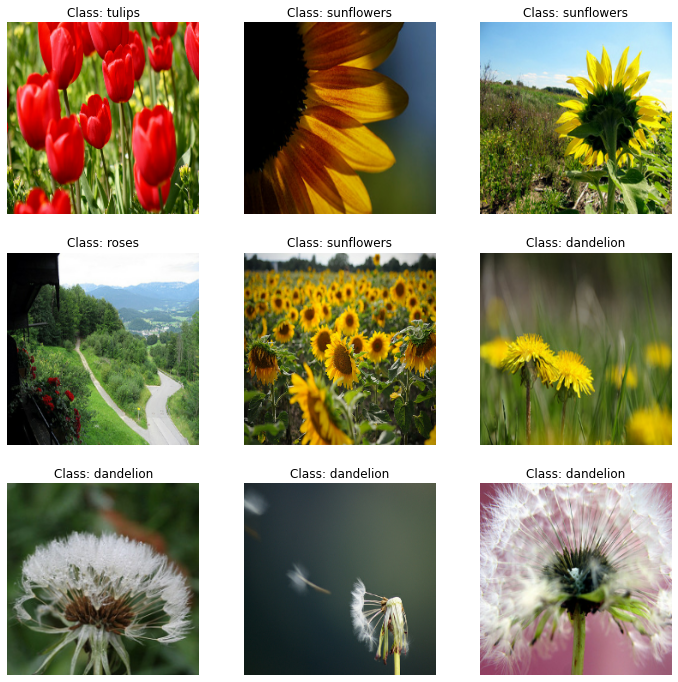

In [16]:
# test_set
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#### **모델 생성**

- 사전훈련된 Xception 모델 로드
- include_top = False
    - 전역 평균 풀링층, 밀집 출력층 제외

In [17]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

- Xception 모델을 기반으로 새로운 전역 평균 풀링 층, 밀집 출력 층 생성

In [18]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

#### **모델 컴파일, 훈련**

- 훈련 초기 사전훈련된 층의 가중치 동결

In [19]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 26s 97ms/step - loss: 1.3185 - accuracy: 0.7958 - val_loss: 1.3184 - val_accuracy: 0.8070
Epoch 2/5
86/86 [==============================] - 8s 89ms/step - loss: 0.5296 - accuracy: 0.9052 - val_loss: 0.9413 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 8s 88ms/step - loss: 0.2386 - accuracy: 0.9426 - val_loss: 0.7249 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 8s 88ms/step - loss: 0.1170 - accuracy: 0.9684 - val_loss: 0.6512 - val_accuracy: 0.8768
Epoch 5/5
86/86 [==============================] - 8s 88ms/step - loss: 0.0744 - accuracy: 0.9753 - val_loss: 0.6573 - val_accuracy: 0.8713


- 검증 정확도 80~90% 도달 및 지속 : 새로 추가한 최상위 층이 잘 훈련되었다는 것을 의미

- 모든 층의 동결을 해제한 이후 훈련 지속
    - 층을 동결하거나 해제 시 반드시 모델 컴파일!
    - 사전훈련된 가중치의 훼손을 방지하기 위해 작은 학습률 사용

In [20]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 38s 396ms/step - loss: 0.3339 - accuracy: 0.8892 - val_loss: 0.7470 - val_accuracy: 0.8382
Epoch 2/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0410 - accuracy: 0.9895 - val_loss: 0.3345 - val_accuracy: 0.9136
Epoch 3/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.2785 - val_accuracy: 0.9283
Epoch 4/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2932 - val_accuracy: 0.9320
Epoch 5/40
86/86 [==============================] - 33s 389ms/step - loss: 4.4745e-04 - accuracy: 1.0000 - val_loss: 0.3072 - val_accuracy: 0.9301
Epoch 6/40
86/86 [==============================] - 33s 389ms/step - loss: 2.5885e-04 - accuracy: 1.0000 - val_loss: 0.3168 - val_accuracy: 0.9320
Epoch 7/40
86/86 [==============================] - 34s 390ms/step - loss: 1.9227e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accu